In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import sys

import matplotlib.pyplot as plt
from batchflow.opensets import MNIST
from batchflow.models.tf import TFModel
from batchflow import Pipeline, L, F, V, D, B, DatasetIndex, Dataset, ImagesBatch, Config

import numpy as np


In [3]:
mnist = MNIST(batch_class=ImagesBatch)

Extracting /tmp/train-images-idx3-ubyte.gz
 http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
DownloadingExtracting /tmp/train-labels-idx1-ubyte.gz
 Extractinghttp://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
 /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


In [219]:
decay_d = ('exp', {'learning_rate': 0.001,
                   'decay_steps': 150,
                   'decay_rate': 0.96})

model_config = {'inputs': dict(images={'shape': (28, 28, 1)},
                               masks={'name': 'targets', 'shape': (28, 28, 1)}),
                'initial_block': {'layout': 'cna'*2,
                                  'filters': [6]*2, 'kernel_size': [3]*2,
                                  'inputs': 'images'},
                'body': {'layout': 'nca nca',
                         'filters': [8, 1],
                         'kernel_size': [3, 3]},
                'head': {'layout': 'nca',
                         'filters': 1,
                         'kernel_size': 3},
                'loss': 'mse',
#                 'optimizer': 'Adam',
                'decay': decay_d,
                'train_steps': {'ALL': {'optimizer': 'RMSProp', 'decay': decay_d},
                                'BODY': {'optimizer': 'Adam', 'scope': 'body',
                                         'loss': ('l1', {'targets': 'body_tensor'})},
                                'HEAD': {'optimizer': 'Adagrad', 'scope': 'head', 'decay': decay_d},
                                'CUSTOM': {'optimizer': 'Adam', 'scope': '-initial_block/layer-0'}},
                'head/units': 10
}

data_dict = {'images': B('images'),
             'masks': B('images')}

train_pipeline = (mnist.train.p
                 .init_variable('loss_history', init_on_each_run=list)
                 .init_variable('current_loss')
                 .to_array()
                 .multiply(multiplier=1/255., preserve_type=False)
                 .init_model('dynamic', TFModel, 'conv', config=model_config)
                 .to_array()
                 .train_model('conv', fetches='lossALL', feed_dict=data_dict, 
                              train_mode='ALL',
                              save_to=V('current_loss'))
                 .update_variable('loss_history', 
                                  V('current_loss'), 
                                  mode='a')
                  )

In [220]:
%%time
n_b = train_pipeline.next_batch(256, n_epochs=None)
# n_b = train_pipeline.run(256, n_epochs=2, bar=True)

ALL {'optimizer': 'RMSProp', 'decay': ('exp', {'learning_rate': 0.001, 'decay_steps': 150, 'decay_rate': 0.96}), 'loss': 'mse', 'scope': ''}
BODY {'optimizer': 'Adam', 'scope': 'body', 'loss': ('l1', {'targets': 'body_tensor'})}
HEAD {'optimizer': 'Adagrad', 'scope': 'head', 'decay': ('exp', {'learning_rate': 0.001, 'decay_steps': 150, 'decay_rate': 0.96}), 'loss': 'mse'}
CUSTOM {'optimizer': 'Adam', 'scope': '-initial_block/layer-0', 'loss': 'mse'}
CPU times: user 3.52 s, sys: 59.6 ms, total: 3.58 s
Wall time: 2.62 s


In [212]:
train_pipeline.get_variable("loss_history")

[0.22392684,
 0.22434843,
 0.21262658,
 0.2124145,
 0.22013944,
 0.22179507,
 0.20962149,
 0.22001843,
 0.2173888,
 0.20388818,
 0.20886436,
 0.20696825,
 0.19790554,
 0.1962062,
 0.20036724,
 0.19418685,
 0.18918361,
 0.19071765,
 0.20120212,
 0.18566778,
 0.18176417,
 0.18156752,
 0.17332649,
 0.18488522,
 0.17421609,
 0.16704243,
 0.16519688,
 0.16631332,
 0.15438373,
 0.15678543,
 0.1551503,
 0.15879048,
 0.1507913,
 0.16866429,
 0.1461765,
 0.1450936,
 0.14108366,
 0.14243738,
 0.13215314,
 0.14065081,
 0.1446984,
 0.12351824,
 0.1292106,
 0.12785485,
 0.12145414,
 0.121539876,
 0.11938493,
 0.11845502,
 0.11282173,
 0.10691304,
 0.113210514,
 0.11424239,
 0.10773719,
 0.09855559,
 0.100007914,
 0.10651512,
 0.09380916,
 0.093357414,
 0.08872865,
 0.085194245,
 0.0853398,
 0.08267387,
 0.08881308,
 0.083202496,
 0.07945569,
 0.076481484,
 0.07824224,
 0.077870555,
 0.073237196,
 0.070745334,
 0.07166807,
 0.070673056,
 0.06790807,
 0.06710681,
 0.06340151,
 0.07066354,
 0.07003811

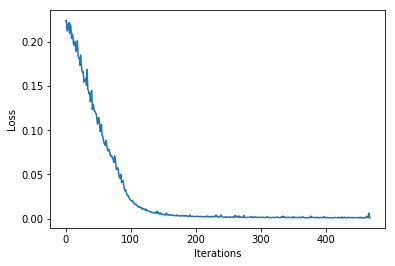

In [213]:
plt.plot(train_pipeline.get_variable("loss_history"))
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.show()

In [114]:
model = train_pipeline.get_model_by_name('conv')

In [ ]:
batch = train_pipeline.next_batch(10, n_epochs=None)

In [ ]:
train_pipeline.get_variable('result')[0][1].shape

In [64]:
model.graph.get_operations()

[<tf.Operation 'TFModel/globals/is_training' type=Placeholder>,
 <tf.Operation 'TFModel/globals/global_step/initial_value' type=Const>,
 <tf.Operation 'TFModel/globals/global_step' type=VariableV2>,
 <tf.Operation 'TFModel/globals/global_step/Assign' type=Assign>,
 <tf.Operation 'TFModel/globals/global_step/read' type=Identity>,
 <tf.Operation 'TFModel/inputs/images' type=Placeholder>,
 <tf.Operation 'TFModel/inputs/labels' type=Placeholder>,
 <tf.Operation 'TFModel/initial_block/layer-0/conv2d/kernel/Initializer/random_uniform/shape' type=Const>,
 <tf.Operation 'TFModel/initial_block/layer-0/conv2d/kernel/Initializer/random_uniform/min' type=Const>,
 <tf.Operation 'TFModel/initial_block/layer-0/conv2d/kernel/Initializer/random_uniform/max' type=Const>,
 <tf.Operation 'TFModel/initial_block/layer-0/conv2d/kernel/Initializer/random_uniform/RandomUniform' type=RandomUniform>,
 <tf.Operation 'TFModel/initial_block/layer-0/conv2d/kernel/Initializer/random_uniform/sub' type=Sub>,
 <tf.Opera

In [ ]:
tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

In [ ]:
class ModifiedTFModel(TFModel):
    
    def __init__(self, *args, **kwargs):
        self.session = kwargs.get('session', None)
        self.graph = tf.Graph() if self.session is None else self.session.graph
        self._graph_context = None
        self.is_training = None
        self.global_step = None
        self.loss = None
        self.train_steps = None
        self._train_lock = threading.Lock()
        self._attrs = []
        self._saver = None
        self._to_classes = {}
        self._inputs = {}
        self.inputs = None

        super().__init__(*args, **kwargs)    

    def build(self, *args, **kwargs):
        def _device_context():
            if 'device' in self.config:
                device = self.config.get('device')
                context = self.graph.device(device)
            else:
                context = contextlib.ExitStack()
            return context


        with self.graph.as_default(), _device_context():
            with tf.variable_scope(self.__class__.__name__):
                with tf.variable_scope('globals'):
                    if self.is_training is None:
                        self.store_to_attr('is_training', tf.placeholder(tf.bool, name='is_training'))
                    if self.global_step is None:
                        self.store_to_attr('global_step', tf.Variable(0, trainable=False, name='global_step'))

                config = self.build_config()
                self._build(config)
                if self.train_steps is None:
                    self._make_loss(config)
                    self.store_to_attr('loss', tf.losses.get_total_loss())

                    ######################
                    if config.get('train_modes') is None:
                        config['train_modes'] = {}
                    
                    _decay = config.get('decay')
                    _optimizer = config.get('optimizer')
                    _scope = config.get('scope')
                    if _optimizer is not None:
                        config['train_modes'].update({'default': {'optimizer': _optimizer,
                                                                  'decay': _decay,
                                                                  'scope': _scope}})
                    
                    for key, subconfig in config.get('train_modes').items():
                        if subconfig.get('optimizer') is None:
                            subconfig.update({'optimizer': _optimizer})
                        if subconfig.get('decay') is None:
                            subconfig.update({'decay': _decay})
                        if subconfig.get('scope') is None:
                            subconfig.update({'scope': _scope})
                    

                    train_steps = {}
                    for key, subconfig in config['train_modes'].items():
                        print('\n\n\nCURRENT KEY: ', key)
                        print('\nSUBCONFIG: ', subconfig)
                        optimizer_ = self._make_optimizer(subconfig)
                        print('\nOPTIMIZER_: ', optimizer_)
                        
                        if optimizer_:
                            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                            with tf.control_dependencies(update_ops):
    
                                scope = subconfig.get('scope')
                                var_scope = self.__class__.__name__ + '/' + scope
                                scope_collection = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                                                     var_scope)
                                
                                pprint(scope_collection)
                                train_step_ = optimizer_.minimize(self.loss,
                                                                  global_step=self.global_step,
                                                                  var_list=scope_collection)
                                train_steps.update({key: train_step_})
                    
                    self.store_to_attr('train_steps', train_steps)
                    print('\n\nTRAIN_STEPS: ', self.train_steps)
                    
                    ######################
                else:
                    self.store_to_attr('train_step', self.train_steps)

            if self.session is None:
                self.create_session(config)
                self.reset()
                
    @classmethod
    def default_config(cls):
        config = Config()
        config['inputs'] = {}
        config['initial_block'] = {}
        config['body'] = {}
        config['head'] = {}
        config['predictions'] = None
        config['output'] = None
        config['optimizer'] = ('Adam', dict())
        config['decay'] = (None, dict())
        config['scope'] = ''
        config['common'] = {'batch_norm': {'momentum': .1}}

        return config                
                
                
    def train(self, fetches=None, feed_dict=None, use_lock=False, train_mode='default', **kwargs):
        print('\n\n TRAIN_MODE IS: ', train_mode)
        print('\n\n CURRENT train_step: ', self.train_steps[train_mode])
        with self.graph.as_default():
            feed_dict = {} if feed_dict is None else feed_dict
            feed_dict = {**feed_dict, **kwargs}
            _feed_dict = self._fill_feed_dict(feed_dict, is_training=True)
            if fetches is None:
                _fetches = tuple()
            else:
                _fetches = self._fill_fetches(fetches, default=None)

            if use_lock:
                self._train_lock.acquire()

            _all_fetches = []
            
            #####
            if self.train_steps:
                _all_fetches += [self.train_steps[train_mode]]
                
                
                #######
            if _fetches is not None:
                _all_fetches += [_fetches]
            if len(_all_fetches) > 0:
                _, output = self.session.run(_all_fetches, feed_dict=_feed_dict)
            else:
                output = None

            if use_lock:
                self._train_lock.release()

            return self._fill_output(output, _fetches)